In [15]:
import numpy as np
import matplotlib.pyplot as plt

In [10]:
def do_graph_random_walks(adj_matrix, edge_indices, num_walks, walk_length):
    num_nodes = adj_matrix.shape[0]
    nodes = np.arange(num_nodes)
    trajectories = []
    for i in range(num_walks):
        trajectory = []
        curr_node = np.random.choice(nodes).item()
        for j in range(walk_length):
            next_node = np.random.choice(np.where(adj_matrix[curr_node] == 1)[0]).item()
            trajectory.append((curr_node, edge_indices[(curr_node, next_node)], next_node))
            curr_node = next_node
        trajectories.append(trajectory)
    return np.array(trajectories)

In [11]:
def gen_random_graph(n_nodes=32, min_degree=2, max_degree=5):
    degrees = np.random.randint(min_degree, max_degree + 1, (n_nodes,))
    if degrees.sum() % 2 != 0:
        adjust_idx = np.random.randint(n_nodes)
        if degrees[adjust_idx] == min_degree:
            degrees[adjust_idx] += 1
        elif degrees[adjust_idx] == max_degree:
            degrees[adjust_idx] -= 1
        else:
            adj = np.random.choice(np.array([-1, 1]))
            degrees[adjust_idx]=degrees[adjust_idx] + adj

    rem_degrees = np.copy(degrees)

    adj_matrix = np.zeros((n_nodes, n_nodes), dtype=np.uint8)
    edges = []
    edge_indices = {}
    edge_idx = 0
    while rem_degrees.sum() != 0:
        i = np.argmax(rem_degrees).item()
        rem_degrees_gz = rem_degrees > 0
        rem_degrees_not_argmax = np.arange(rem_degrees.size) != i
        pending_edges = np.where(rem_degrees_gz & rem_degrees_not_argmax)[0]
        j = np.random.choice(pending_edges).item()

        # find a better way to do this?
        if (i, j) in edges:
            continue

        edges.append((i,j))
        edge_indices[(i,j)] = edge_idx
        edge_idx += 1
        edges.append((j,i))
        edge_indices[(j,i)] = edge_idx
        edge_idx += 1
        rem_degrees[i] -= 1
        rem_degrees[j] -= 1

    for i, j in edges:
        adj_matrix[i, j] = 1

    return adj_matrix, edge_indices

In [13]:
adj_matrix, edge_indices = gen_random_graph()
num_walks = 200
walk_length = 32
trajectories = do_graph_random_walks(adj_matrix, edge_indices, num_walks, walk_length)

In [84]:
n_obs = adj_matrix.shape[0]
n_act = len(edge_indices)
emb_dim = 1000
Q_init_stddev = 1.0
V_init_stddev = 0.1
W_init_stddev = 0.1
eta_q = 0.1
eta_v = 0.01
eta_w = 0.01
num_epochs = 10

In [138]:
np.random.seed(0)
Q = np.random.normal(size=(emb_dim, n_obs)) * Q_init_stddev
V = np.random.normal(size=(emb_dim, n_act)) * V_init_stddev
W = np.random.normal(size=(n_act, emb_dim)) * W_init_stddev

In [132]:
num_trajectories = trajectories.shape[0]
mses1 = []
for epoch in range(num_epochs):
    print(f"epoch {epoch}")
    for traj_idx in range(num_trajectories):
        nodes = trajectories[traj_idx, :, 0]
        edges = trajectories[traj_idx, :, 1]
        next_nodes = trajectories[traj_idx, :, 2]

        s_curr_DxL = Q[:, nodes]
        s_next_DxL = Q[:, next_nodes]

        s_diff_DxL = s_next_DxL - s_curr_DxL
        pred_err_DxL = s_diff_DxL - V[:, edges]

        V[:, edges] += eta_v * pred_err_DxL
        Q[:, next_nodes] += - eta_q * pred_err_DxL
        W[edges, :] += eta_w * s_diff_DxL.T
        mses1.append((pred_err_DxL ** 2).mean())

epoch 0
epoch 1
epoch 2
epoch 3
epoch 4
epoch 5
epoch 6
epoch 7
epoch 8
epoch 9


In [139]:
num_trajectories = trajectories.shape[0]
mses2 = []
for epoch in range(num_epochs):
    print(f"epoch {epoch}")
    for traj_idx in range(num_trajectories):
        nodes = trajectories[traj_idx, :, 0]
        edges = trajectories[traj_idx, :, 1]
        next_nodes = trajectories[traj_idx, :, 2]
        
        cur_obs = np.zeros((Q.shape[1], len(nodes)))
        for idx, node in enumerate(nodes):
            cur_obs[node, idx] = 1
        next_obs = np.zeros((Q.shape[1], len(next_nodes)))
        for idx, node in enumerate(next_nodes):
            next_obs[node, idx] = 1
        actions = np.zeros((V.shape[1], len(edges)))
        for idx, edge in enumerate(edges):
            actions[edge, idx] = 1

        s_curr_DxL = Q@cur_obs
        s_next_DxL = Q@next_obs

        s_diff_DxL = s_next_DxL - s_curr_DxL
        pred_err_DxL = s_diff_DxL - V@actions

        V += eta_v * pred_err_DxL@actions.T
        Q += eta_q * pred_err_DxL@(- next_obs).T
        W += eta_w * actions@s_diff_DxL.T
        mses2.append((pred_err_DxL ** 2).mean())

epoch 0
epoch 1
epoch 2
epoch 3
epoch 4
epoch 5
epoch 6
epoch 7
epoch 8
epoch 9


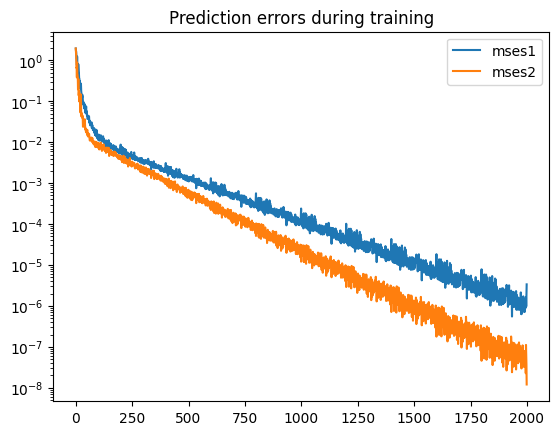

In [140]:
fig, ax = plt.subplots()
ax.plot(mses1, label='mses1')
ax.plot(mses2, label='mses2')
ax.set_title('Prediction errors during training')
ax.set_yscale('log')
plt.legend()
plt.show()
plt.close(fig)